# Calibrating DRAG pulses

## Methods
The whole set of gates for a single qubit can be modeled with $x$, $\sqrt{x}$, $u1$, $u2$, and $u3$ gates. The $\sqrt{x}$ and $x$ rotations are usually generated by a Gaussian pulse and the rotations about z-axis can be track efficiently by virtual rotation. The Gaussian pulse is given by the equation: 

$$\theta(t) = A e^{-\frac{1}{2}\left(\frac{t - \tau/2}{\sigma}\right)^2}$$

where A is the amplitude of the pulse that generates the wanted rotation, t is the time, $\tau$ is the pulse length and $\sigma$ is the pulse width. Usually, the pulse is truncated and the pulse length is set to $\tau = 4\sigma$

$$\theta(t) = A \frac{e^{-\frac{1}{2}\left(\frac{t - \tau/2}{\sigma}\right)^2} - e^{-\frac{1}{2}\left(\frac{\tau/2}{\sigma}\right)^2}}{1 - e^{-\frac{1}{2}\left(\frac{\tau/2}{\sigma}\right)^2}}$$

In [23]:
from qiskit import IBMQ
from qiskit import QuantumCircuit, transpile
from qiskit import schedule
from qiskit.pulse import DriveChannel, Waveform
from qiskit.circuit import Parameter
from qiskit.tools import job_monitor
from qiskit import pulse
import numpy as np
import matplotlib.pyplot as plt

In [3]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research', group='guanajuato-1', project='main')
backend = provider.backend.ibmq_bogota

ibmqfactory.load_account:WARNING:2021-07-02 05:34:28,808: Credentials are already in use. The existing account in the session will be replaced.


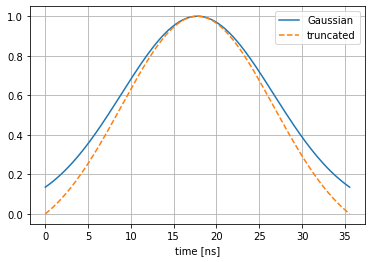

In [22]:
dt = backend.configuration().dt
measure = backend.defaults().instruction_schedule_map.get('measure',qubits = [0])
n = 160
tau = n*dt
sigma = tau/4
time = np.linspace(0,tau,n)
theta = lambda t: np.exp(-0.5*((t - tau/2)/sigma)**2)
gaussian = theta(time)
gauss_trunc = (theta(time) - theta(0))/(1 - theta(0))
fig, ax = plt.subplots()
ax.plot(time*1e9, gaussian, label="Gaussian")
ax.plot(time*1e9, gauss_trunc, '--', label="truncated")
ax.set_xlabel("time [ns]")
ax.legend()
plt.grid()

### Default X pulse
Qiskit has its own calibrated gates. Below, it is shown the default pulse for a x gate, it is a DRAG pulse.

Amplitude = (0.1910093503188872+0j), beta = -1.188836746915842, duration = 160, sigma = 40


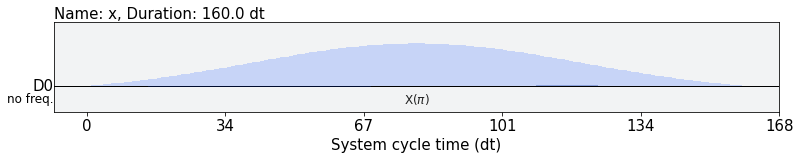

In [21]:
x_def = backend.defaults().instruction_schedule_map.get('x',qubits = [0])
x_def_pulse = x_def.instructions[0][1].pulse
print(f"amplitude = {x_def_pulse.amp}, beta = {x_def_pulse.beta}, duration = {x_def.duration}, sigma = {x_def_pulse.sigma}")
x_def.draw()


amplitude = (0.09533724535243952+0.0010552335963538364j), beta = -1.190001191409393, duration = 160, sigma = 40


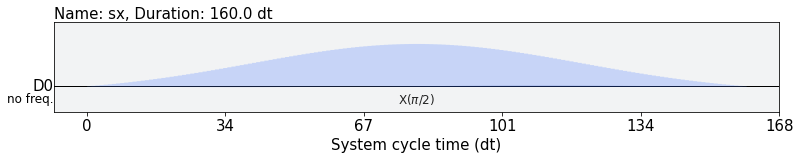

In [26]:
sx_def = backend.defaults().instruction_schedule_map.get('sx',qubits = [0])
sx_def_pulse = sx_def.instructions[0][1].pulse
print(f"amplitude = {sx_def_pulse.amp}, beta = {sx_def_pulse.beta}, duration = {sx_def.duration}, sigma = {sx_def_pulse.sigma}")
sx_def.draw()

### Calibration of the amplitude of the SX and X gate
Using the approach of Sheldon et. al. [1], we calibrate the amplitude of the Gaussian pulse and the quadrature with a sequence of pulses.

[1] Characterizing errors on qubit operations via iterative randomized benchmarking


In [170]:
# Calibration of sx
duration = 160
sigma = 40
guess_amp = 0.1
sx = pulse.Gaussian(duration, guess_amp, sigma, name="sx") # Gaussian Pulse for the sx gate
n = 10 # Number of repetitions
schedules = []
for i in range(n):
    with pulse.build() as sched:
        with pulse.align_sequential():
            pulse.play(sx, DriveChannel(0))
            for j in range(i):
                pulse.play(sx, DriveChannel(0))
                pulse.play(sx, DriveChannel(0))
            pulse.call(measure)
    schedules.append(sched)

In [172]:
job = backend.run(schedules)
job_monitor(job)

Job Status: job has successfully run


In [173]:
counts = job.result().get_counts()

In [174]:
def probability(counts):
    all_exp = []
    for j in counts:
        zero = 0
        for i in j.keys():
            if i[-1] == "0":
                zero += j[i]
        all_exp.append(zero)
    return np.array(all_exp)/ 1024

### Amplitude calibration based on the paper of Sheldon 2015
Using equation 4 of Sheldon 2015.
$$P(|0\rangle) = a + \frac{1}{2}(-1)^n cos\left(\frac{\pi}{2} + 2n\epsilon\right)$$

In [175]:
from scipy.optimize import curve_fit

The error angle 0.08826228198131922, the new amplitude 0.09467997806018291


Text(0, 0.5, '$P(|0\\rangle)$')

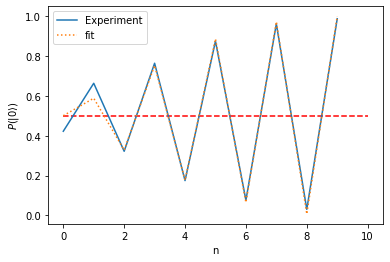

In [179]:
cal1 = probability(counts)
func = lambda n, a, epsilon: a + 0.5 * (-1)**n * np.cos(0.5 * np.pi + 2 * n * epsilon) 

fit = curve_fit(func, np.arange(n), cal1, [0.5,0.1])
e = fit[0][1]
amp_new = guess_amp * (1/(1 + 2*e/np.pi))
print(f"The error angle {e}, the new amplitude {new_amp}")

plt.figure()
plt.plot(np.arange(n),cal1, label="Experiment")
plt.hlines(0.5,0,10, linestyle="--", color="r")
plt.plot(np.arange(n),func(np.arange(n), *fit[0]),":", label="fit")
plt.legend()
plt.xlabel("n")
plt.ylabel(r"$P(|0\rangle)$")

In [180]:
sx = pulse.Gaussian(duration, amp_new, sigma, name="sx") # Gaussian Pulse for the sx gate
n = 20 # Number of repetitions
schedules = []
for i in range(n):
    with pulse.build() as sched:
        with pulse.align_sequential():
            pulse.play(sx, DriveChannel(0))
            for j in range(i):
                pulse.play(sx, DriveChannel(0))
                pulse.play(sx, DriveChannel(0))
            pulse.call(measure)
    schedules.append(sched)

In [181]:
job = backend.run(schedules)
job_monitor(job)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run


In [182]:
counts = job.result().get_counts()

The error angle -0.007440133867122852, the new amp 0.0951305674488908


Text(0, 0.5, '$P(|0\\rangle)$')

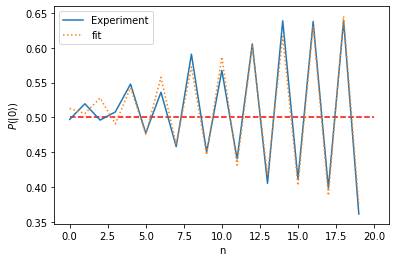

In [184]:
cal2 = probability(counts)
func = lambda n, a, epsilon: a + 0.5 * (-1)**n * np.cos(0.5 * np.pi + 2 * n * epsilon) 
fit2 = curve_fit(func, np.arange(n), cal2, [0.5,0.05])
e = fit2[0][1]
new_amp2 = new_amp/(1 + 2*e/np.pi)
print(f"The error angle {fit2[0][1]}, the new amp {new_amp2}")

plt.figure()
plt.plot(np.arange(n),cal2, label="Experiment")
plt.hlines(0.5,0,n, linestyle="--", color="r")
plt.plot(np.arange(n),func(np.arange(n), *fit2[0]),":", label="fit")
plt.legend()
plt.xlabel("n")
plt.ylabel(r"$P(|0\rangle)$")

# Classification of the states
## Finding the qubit frequency and amplitude for the state |2>


In [186]:
from qiskit.pulse import Gaussian

In [198]:
qubit = 0
amp = 0.4
n = 160
spec_pulse = Gaussian(duration=n, amp=amp, sigma=(n//4))
measure = backend.defaults().instruction_schedule_map.get('measure',qubits = [qubit])
num_exp = 20# number of experiments
f01 = backend.defaults().qubit_freq_est[0]
frequencies = f01 - np.linspace(0,0.4e9,num_exp)
scheds = []
for f in frequencies:
    with pulse.build() as Schedule:
        with pulse.align_sequential():
            pulse.call(x_def)
            pulse.set_frequency(f, DriveChannel(qubit))
            pulse.play(spec_pulse, DriveChannel(qubit))
            pulse.call(measure)
    scheds.append(Schedule)

In [192]:
shots = 1000
job = backend.run(scheds, meas_level=1, meas_return="single", shots=shots)
job_monitor(job)
result = job.result()

Job Status: job is being validated

KeyboardInterrupt: 

### Finding the frequency

In [208]:
output = []
for i in range(num_exp):
    output.append(result.get_memory(i))
output = np.array(output)
output = np.squeeze(output)[:,:,0]

In [209]:
output.shape

(20, 1000)

Text(0.5, 1.0, 'Frequency calibrated 4663576319.761971')

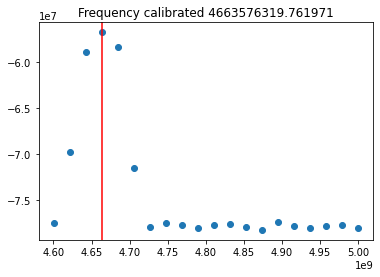

In [211]:
mean = np.mean(output, axis=1)
f12 = frequencies[np.argmax(mean.imag)]
plt.scatter(frequencies, mean.imag)
plt.axvline(f12, color="red")
plt.title(f"Frequency calibrated {f12}")

### Finding the amplitude

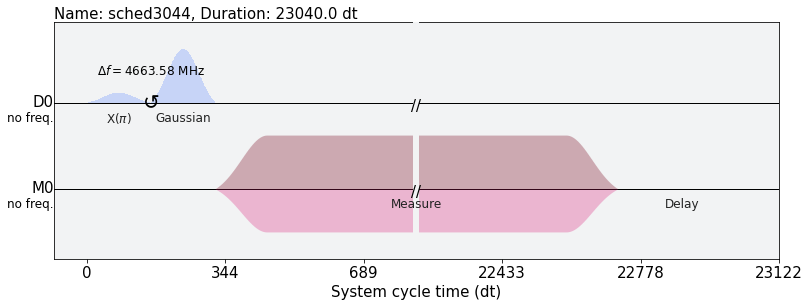

In [217]:
scheds = []
amplitudes = np.linspace(0,1,75)
for amp in amplitudes:
    spec_pulse = Gaussian(duration=n, amp=amp, sigma=(n//4))
    with pulse.build() as Schedule:
        with pulse.align_sequential():
            pulse.call(x_def)
            pulse.set_frequency(f12, DriveChannel(qubit))
            pulse.play(spec_pulse, DriveChannel(qubit))
            pulse.call(measure)
    scheds.append(Schedule)
scheds[-1].draw()

In [218]:
shots = 1000
job_amp = backend.run(scheds, meas_level=1, meas_return="single", shots=shots)
job_monitor(job_amp)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run


In [221]:
results = job_amp.result()

In [225]:
amp_cal = []
for i in range(75):
    amp_cal.append(results.get_memory(i))
amp_cal = np.array(amp_cal)
amp_cal = np.squeeze(amp_cal)[:,:,0]

Text(0.5, 1.0, 'The amplitude for the transition 1-2 is :0.162')

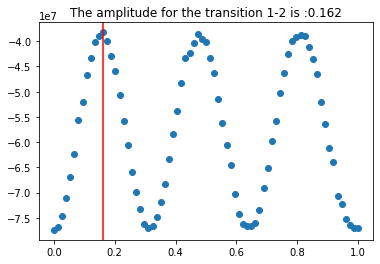

In [227]:
mean_amp = np.mean(amp_cal, axis=1)
amp12 = amplitudes[np.argmax(mean_amp.imag)]
plt.plot(amplitudes,mean_amp.imag, "o")
plt.axvline(amp12, color="red")
# plt.scatter(amp_cal[-1].real, amp_cal[-1].imag)
plt.title(f"The amplitude for the transition 1-2 is :{round(amp12,3)}")

### Classification of the three states

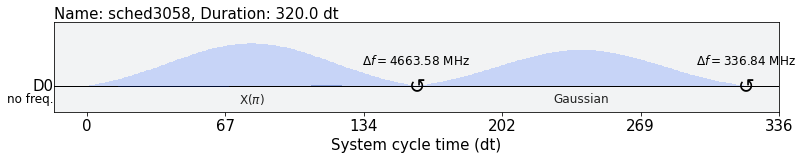

In [228]:
x01 = backend.defaults().instruction_schedule_map.get('x', qubits = [0]) # Gate X to rotate in the |0> |1> basis
f01 = backend.defaults().qubit_freq_est[0]
spec_pulse = Gaussian(duration=n, amp=amp12, sigma=(n//4))
with pulse.build() as pulse12:
    with pulse.align_sequential():
        pulse.set_frequency(f12, DriveChannel(qubit))
        pulse.play(spec_pulse, DriveChannel(qubit))
        pulse.set_frequency(f01, DriveChannel(qubit))
x12 = pulse12
x02 = pulse.Schedule()
x02 += x01
x02 += x12
# |0>
zero = pulse.Schedule()
zero += measure
# |1>
one = pulse.Schedule()
one += x01
one |= measure << one.duration
# |2>
two = pulse.Schedule()
two += x02
two |= measure << two.duration

x02.draw()

In [229]:
classExp = backend.run([zero, one, two], meas_level=1, meas_return="single", shots=shots)
job_monitor(classExp)

/opt/anaconda3/lib/python3.8/site-packages/qiskit/compiler/assembler.py:309: RuntimeWarning: Dynamic rep rates are supported on this backend. 'rep_delay' will be used instead of 'rep_time'.
  warnings.warn("Dynamic rep rates are supported on this backend. 'rep_delay' will be "


Job Status: job has successfully run


In [230]:
resClass = classExp.result()

In [237]:
result = []
for i in range(3):
    result.append([resClass.get_memory(i).real[:,0], resClass.get_memory(i)[:,0].imag])
result = np.squeeze(np.array(result)).T

(1000, 2, 3)

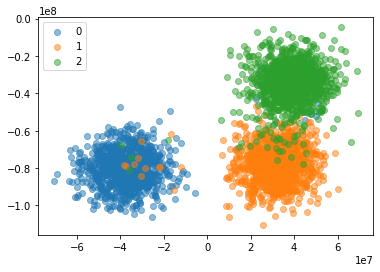

In [239]:
for i in range(3):
    plt.scatter(result[:,0,i], result[:,1,i], label = f"{i}", alpha = 0.5)
plt.legend()
len(result[0])
result.shape

In [241]:
from sklearn.cluster import KMeans

In [242]:
X = np.concatenate((result[:,:,0], result[:,:,1],result[:,:,2]))
kmeans = KMeans(n_clusters=3).fit(X)

[[0.971, 0.026, 0.003], [0.012, 0.016, 0.972], [0.004, 0.959, 0.037]]

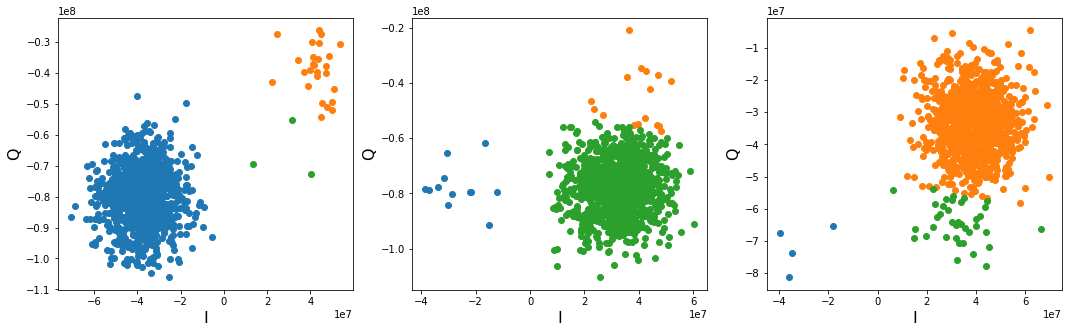

In [243]:
fig, ax = plt.subplots(1,3, figsize=(18,5))
count = []
for j in range(3):
    case = 2
    pred0 = kmeans.predict(result[:,:,j])
    for i in range(3):
        pred = result[pred0==i,:,j]
        ax[j].scatter(pred[:,0],pred[:,1], label=f"{i}")
    ax[j].set_xlabel("I", fontsize=16)
    ax[j].set_ylabel("Q", fontsize=16)
    count.append([np.sum(pred0==i)/len(pred0) for i in range(3)])
count